In [126]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from torchvision import datasets, transforms

In [127]:
# Load FashionMNIST Dataset
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


# Convert to numpy for easy handling
X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

# Normalize data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [128]:
def one_hot_encode(y, num_classes):
  one_hot = np.zeros((len(y), num_classes))
  one_hot[np.arange(len(y)), y] = 1
  return one_hot

# y_train = one_hot_encode(y_train, 10)
# y_val = one_hot_encode(y_val, 10)
# y_test = one_hot_encode(y_test, 10)

In [129]:
class Dense:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
    
    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)



In [130]:
class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        return grad_output * (self.input > 0)

In [131]:
class BatchNorm:
    def __init__(self, dim, eps=1e-5, momentum=0.9):
        self.gamma = np.ones((1, dim))
        self.beta = np.zeros((1, dim))
        self.eps = eps
        self.momentum = momentum
        self.running_mean = np.zeros((1, dim))
        self.running_var = np.ones((1, dim))
    
    def forward(self, x, train=True):
        if train:
            mean = x.mean(axis=0)
            var = x.var(axis=0)
            self.normalized = (x - mean) / np.sqrt(var + self.eps)
            self.x_centered = x - mean
            self.std_inv = 1. / np.sqrt(var + self.eps)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            self.normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
        
        return self.gamma * self.normalized + self.beta

    def backward(self, grad_output):
        grad_gamma = np.sum(grad_output * self.normalized, axis=0)
        grad_beta = np.sum(grad_output, axis=0)
        grad_norm = grad_output * self.gamma
        grad_input = (1. / grad_output.shape[0]) * self.std_inv * (grad_output.shape[0] * grad_norm - np.sum(grad_norm, axis=0) - self.normalized * np.sum(grad_norm * self.normalized, axis=0))
        self.grad_gamma, self.grad_beta = grad_gamma, grad_beta
        return grad_input


In [132]:
class Dropout:
    def __init__(self, rate=0.5):
        self.rate = rate

    def forward(self, x, train=True):
        if train:
            self.mask = (np.random.rand(*x.shape) > self.rate) / (1 - self.rate)
            return x * self.mask
        return x
    
    def backward(self, grad_output):
        return grad_output * self.mask


In [133]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self, params, grads):
        if not self.m:
            # Initialize m and v with the same shape as params
            self.m = [np.zeros_like(param) for param in params]
            self.v = [np.zeros_like(param) for param in params]

        self.t += 1
        for i, (param, grad) in enumerate(zip(params, grads)):
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            # Compute bias-corrected first and second moment estimates
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            # Update parameters
            # print(f"param shape: {param.shape} | grad shape: {grad.shape} | m_hat shape: {m_hat.shape} | v_hat shape: {v_hat.shape} ")
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)


In [134]:
class ModelA:
    def __init__(self):
        self.layers = [
            Dense(784, 128),
            ReLU(),

            Dense(128, 64),
            ReLU(),

            Dense(64, 10)  
        ]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x 
    
    def backward(self, grad_loss):
        grad = grad_loss
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

In [135]:
class ModelB:
    def __init__(self):
        self.layers = [
            Dense(784, 324),
            ReLU(),
            Dropout(),

            Dense(324, 128),
            ReLU(),
            Dropout(),

            Dense(128, 64),
            ReLU(),

            Dense(64, 10)
        ]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x  # Output logits directly
    
    def backward(self, grad_loss):
        grad = grad_loss
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

In [136]:
class ModelC:
    def __init__(self):
        self.layers = [
            Dense(784, 324),
            BatchNorm(324),
            ReLU(),
            Dropout(),

            Dense(324, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(),

            Dense(128, 64),
            BatchNorm(64),
            ReLU(),

            Dense(64, 10)
        ]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x  # Output logits directly
    
    def backward(self, grad_loss):
        grad = grad_loss
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

In [137]:
# Cell 10: Define Training Function
def softmax_crossentropy_with_logits(logits, y_true):
    exp_values = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    loss = -np.log(probabilities[range(len(y_true)), y_true])
    return np.mean(loss), probabilities


In [138]:
def save_model_parameters(model, model_name, lr):
    params = []
    for layer in model.layers:
        layer_params = {}
        if isinstance(layer, Dense):
            layer_params['type'] = 'Dense'
            layer_params['weights'] = layer.weights
            layer_params['bias'] = layer.bias
            params.append(layer_params)
        elif isinstance(layer, BatchNorm):
            layer_params['type'] = 'BatchNorm'
            layer_params['gamma'] = layer.gamma
            layer_params['beta'] = layer.beta
            layer_params['running_mean'] = layer.running_mean
            layer_params['running_var'] = layer.running_var
            params.append(layer_params)
    
    # Save parameters to a file
    with open(f"saved_models/{model_name}_{lr}_params.pkl", "wb") as f:
        pickle.dump(params, f)

def load_model_parameters(model, model_name, lr):
    with open(f"saved_models/{model_name}_{lr}_params.pkl", "rb") as f:
        params = pickle.load(f)

    for layer in model.layers:
        if isinstance(layer, Dense):
            layer_params = params.pop(0)
            layer.weights = layer_params['weights']
            layer.bias = layer_params['bias']
        elif isinstance(layer, BatchNorm):
            layer_params = params.pop(0)
            layer.gamma = layer_params['gamma']
            layer.beta = layer_params['beta']
            layer.running_mean = layer_params['running_mean']
            layer.running_var = layer_params['running_var']

In [139]:

def train(model, X_train, y_train, X_val, y_val, num_epochs, lr, batch_size):
    # Split the training set into training and validation sets
    optimizer = Adam(lr=lr)
    
    # Initialize lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_f1_scores = []
    all_preds, all_labels = [], []

    for epoch in range(num_epochs):
        # Training phase
        batch_losses = []
        batch_preds, batch_labels = [], []
        
        for batch_idx in range(0, len(X_train), batch_size):
            # Get batch data
            X_batch = X_train[batch_idx:batch_idx+batch_size]
            y_batch = y_train[batch_idx:batch_idx+batch_size]

            # Forward pass
            logits = model.forward(X_batch)
            loss, probabilities = softmax_crossentropy_with_logits(logits, y_batch)
            batch_losses.append(loss)
            
            # Store predictions and labels for accuracy calculation
            batch_preds.extend(np.argmax(probabilities, axis=1))
            batch_labels.extend(y_batch)
            
            # Calculate the gradient of the loss w.r.t. logits
            grad_loss = probabilities
            grad_loss[range(len(y_batch)), y_batch] -= 1
            grad_loss /= len(y_batch)
            
            # Backward pass
            model.backward(grad_loss)
            
            params = [layer.weights for layer in model.layers if isinstance(layer, Dense)]
            params.extend([layer.bias for layer in model.layers if isinstance(layer, Dense)])
            grads = [layer.grad_weights for layer in model.layers if isinstance(layer, Dense)]
            grads.extend([layer.grad_bias for layer in model.layers if isinstance(layer, Dense)])
            optimizer.step(params, grads)
            
        
        # Calculate training metrics
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)
        train_accuracy = accuracy_score(batch_labels, batch_preds)
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_logits = model.forward(X_val)
        val_loss, val_probabilities = softmax_crossentropy_with_logits(val_logits, y_val)
        val_losses.append(val_loss)

        # Validation metrics
        val_preds = np.argmax(val_probabilities, axis=1)
        val_accuracy = accuracy_score(y_val, val_preds)
        val_accuracies.append(val_accuracy)
        val_f1 = f1_score(y_val, val_preds, average='weighted')
        val_f1_scores.append(val_f1)
        
        # Store all validation predictions and labels for confusion matrix
        all_preds.extend(val_preds)
        all_labels.extend(y_val)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

    # Save the trained model as a pickle file
    model_name = model.__class__.__name__
    save_model_parameters(model, model_name, lr)

    # Return metrics and model data
    return train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores, all_preds, all_labels


Training ModelA with LR=0.001
Epoch 1/20 - Train Loss: 0.7380, Train Acc: 0.7275, Val Loss: 0.5540, Val Acc: 0.8053, Val F1: 0.7997
Epoch 2/20 - Train Loss: 0.4752, Train Acc: 0.8318, Val Loss: 0.4594, Val Acc: 0.8382, Val F1: 0.8358
Epoch 3/20 - Train Loss: 0.4160, Train Acc: 0.8502, Val Loss: 0.4140, Val Acc: 0.8558, Val F1: 0.8538
Epoch 4/20 - Train Loss: 0.3805, Train Acc: 0.8628, Val Loss: 0.3894, Val Acc: 0.8649, Val F1: 0.8637
Epoch 5/20 - Train Loss: 0.3557, Train Acc: 0.8709, Val Loss: 0.3697, Val Acc: 0.8702, Val F1: 0.8693
Epoch 6/20 - Train Loss: 0.3363, Train Acc: 0.8773, Val Loss: 0.3585, Val Acc: 0.8744, Val F1: 0.8738
Epoch 7/20 - Train Loss: 0.3198, Train Acc: 0.8825, Val Loss: 0.3556, Val Acc: 0.8748, Val F1: 0.8740
Epoch 8/20 - Train Loss: 0.3059, Train Acc: 0.8881, Val Loss: 0.3563, Val Acc: 0.8762, Val F1: 0.8754
Epoch 9/20 - Train Loss: 0.2931, Train Acc: 0.8925, Val Loss: 0.3509, Val Acc: 0.8786, Val F1: 0.8778
Epoch 10/20 - Train Loss: 0.2818, Train Acc: 0.8969,

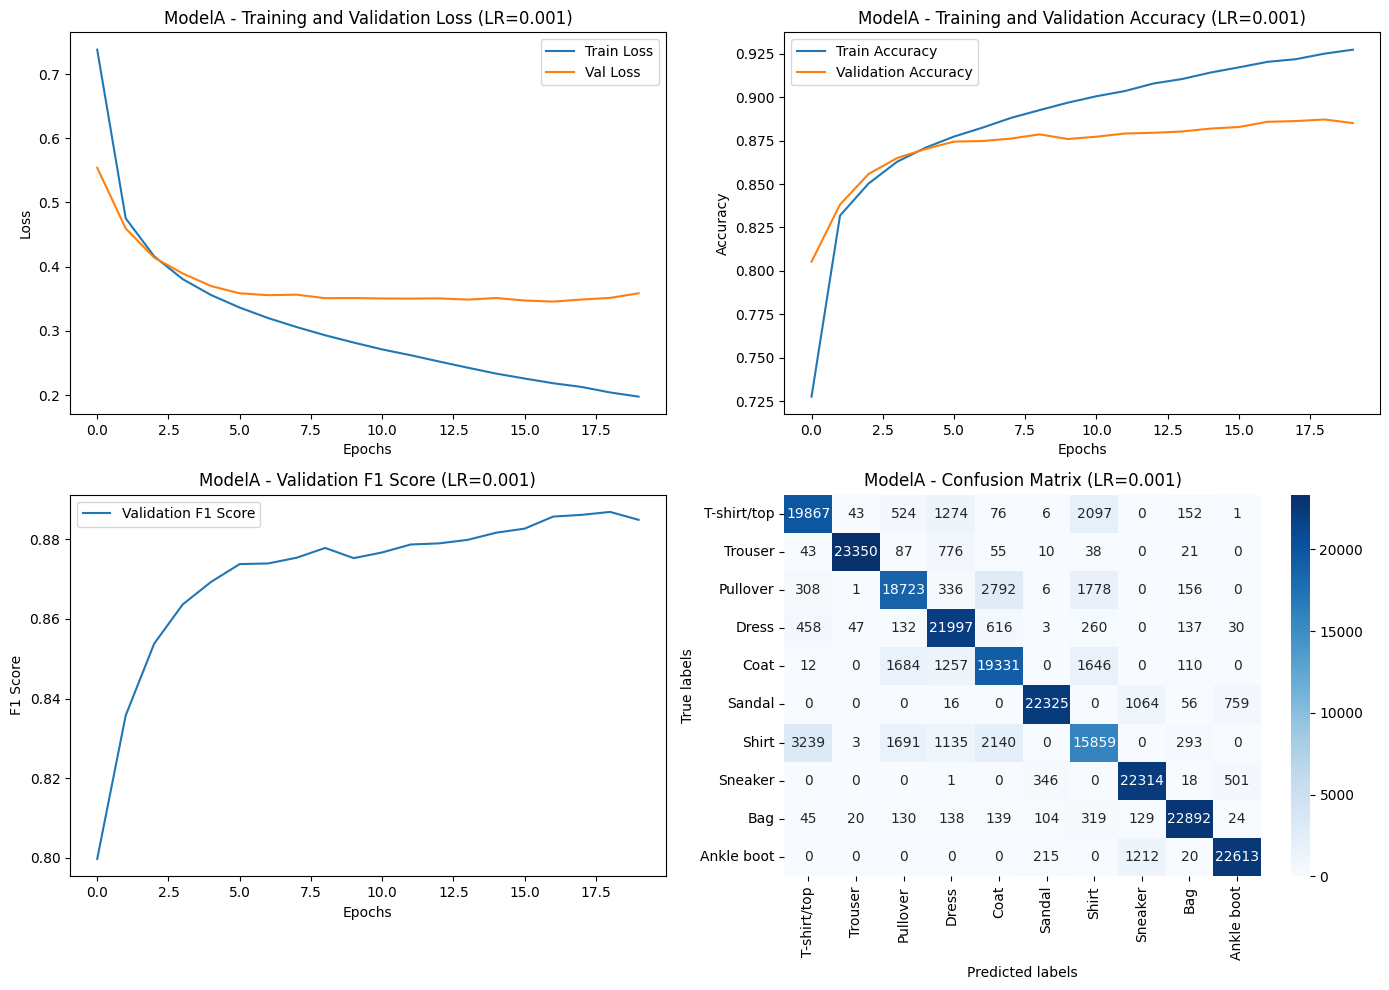

In [140]:
# model_names = ["ModelA", "ModelB", "ModelC"]
# learning_rates = [0.005, 0.001, 0.0005, 0.0001]
model_names = ["ModelA"]
learning_rates = [0.001]
results = {}

for model_name in model_names:
    for lr in learning_rates:
        model = globals()[model_name]()
        print(f"Training {model_name} with LR={lr}")
        train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores, all_preds, all_labels = train(
            model, X_train.reshape(-1, 784), y_train, X_val.reshape(-1, 784), y_val, num_epochs=20, lr=lr, batch_size=64
        )

        results[(model_name, lr)] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "val_f1_scores": val_f1_scores
        }

        # Plot training and validation losses and accuracies
        plt.figure(figsize=(14, 10))

        # Loss Plot
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f"{model_name} - Training and Validation Loss (LR={lr})")

        # Accuracy Plot
        plt.subplot(2, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f"{model_name} - Training and Validation Accuracy (LR={lr})")

        # F1 Score Plot
        plt.subplot(2, 2, 3)
        plt.plot(val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title(f"{model_name} - Validation F1 Score (LR={lr})")

        # Confusion Matrix Plot
        plt.subplot(2, 2, 4)
        cm = confusion_matrix(all_labels, all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f"{model_name} - Confusion Matrix (LR={lr})")

        plt.tight_layout()
        plt.show()


In [141]:
best_model_name, best_lr, best_f1_score = None, None, 0

for (model_name, lr), metrics in results.items():
    max_f1 = max(metrics["val_f1_scores"])
    if max_f1 > best_f1_score:
        best_f1_score = max_f1
        best_model_name, best_lr = model_name, lr

print(f"Best Model: {best_model_name} with Learning Rate: {best_lr} and Macro-F1 Score: {best_f1_score}")


Best Model: ModelA with Learning Rate: 0.001 and Macro-F1 Score: 0.8868963692732599


In [142]:
def load_and_test_model(model_path, X_test, y_test):
    model_file = model_path.split('/')[1]
    lr = float(model_file.split('_')[1])
    model = globals()[model_name]()
    load_model_parameters(model, model_name, lr)
    
    test_logits = model.forward(X_test)
    test_probabilities = np.exp(test_logits) / np.sum(np.exp(test_logits), axis=1, keepdims=True)
    test_preds = np.argmax(test_probabilities, axis=1)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, average='weighted')
    print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f"Confusion Matrix for Test Data")
    plt.show()

Test Accuracy: 0.8782, Test F1 Score: 0.8783


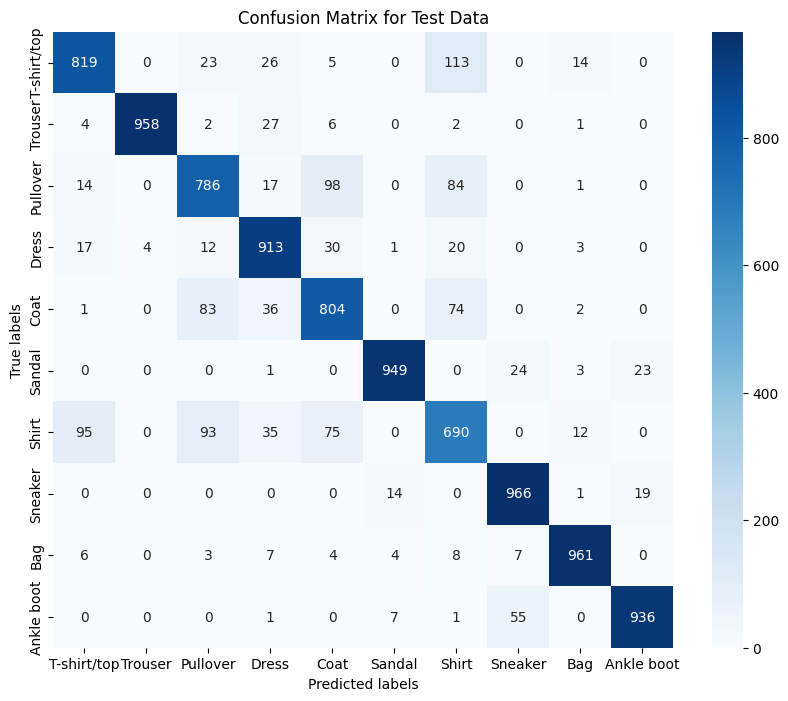

In [143]:
load_and_test_model(f"saved_models/{best_model_name}_{best_lr}_params.pkl", X_test.reshape(-1, 784), y_test)